# Employee Churn - Exploratory Analysis

The aim of this notebook is to understand why an employee is willing to leave its job.

In particular, we have some sociodemographic data to explore to find relationships from.

This falls in a **binary classification** problem, as the target variable, 'target', can only assume 2 values
i.e. either loyal (0.0) or not (1.0) 

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Loading the dataset

In this section we define the path of the dataset of interest, and we load it as **Pandas DataFrame**

In [3]:
# Define the dataset path
data_path = 'datasets/employee-churn'
file_path = os.path.join(data_path, 'churn.csv')

In [4]:
# load the dataset as pd dataframe
df = pd.read_csv(file_path)
# let's plot few rows to understand a first glance the data
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


From these few rows we can alredy get some features properties, such as the column names, the data types, and the presence of NaN values.

To have a deeper view, let's exploit the info() method

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

We are now aware that the dataset is composed by 13 features, and a target variable.

We can basically identify 3 data types:

- int64: 2 instances, i.e. enrollee_id and training_hours
- float64: 2 instances, i.e. city_development_index and the target
- object, a.k.a. string: 10 instances, the remaining features

We can notice that we have 19158 entries. Moreover, we know that 8 out of 13 feature are characterized by the presence of NaN values


## Preprocessing the dataset

Comparing the info's output with the head method, we can quickly spot that some variables are represented as string, but a integer representation would be more straightforward.

To understand better, let's plot the values assumed for those features.

In [6]:
for feature in df.columns[3:12]:
        print(feature.upper())
        print(df[feature].unique())

GENDER
['Male' nan 'Female' 'Other']
RELEVENT_EXPERIENCE
['Has relevent experience' 'No relevent experience']
ENROLLED_UNIVERSITY
['no_enrollment' 'Full time course' nan 'Part time course']
EDUCATION_LEVEL
['Graduate' 'Masters' 'High School' nan 'Phd' 'Primary School']
MAJOR_DISCIPLINE
['STEM' 'Business Degree' nan 'Arts' 'Humanities' 'No Major' 'Other']
EXPERIENCE
['>20' '15' '5' '<1' '11' '13' '7' '17' '2' '16' '1' '4' '10' '14' '18'
 '19' '12' '3' '6' '9' '8' '20' nan]
COMPANY_SIZE
[nan '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49' '100-500'
 '500-999']
COMPANY_TYPE
[nan 'Pvt Ltd' 'Funded Startup' 'Early Stage Startup' 'Other'
 'Public Sector' 'NGO']
LAST_NEW_JOB
['1' '>4' 'never' '4' '3' '2' nan]


As expected, some features are represented as strings, but they can actually be transformed into int without losing interpretability.

- To do so, we can start by removing the 'city_' prefix from the city feature.
- Then, we can think the strings with \<x (with x a number) as the nearest lower integer, and the opposite for the string \>x.
- For the company size instead, we can adopt the interval lower end.
- Finally, we can safely assume that when a value is NaN, the user did not specify any value, thus we can all transform that to -1, to be a separate group

In [7]:
# Let's convert the city feature to int
df['city'] = df['city'].map(lambda row: int(row.split('_')[1]))
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [8]:
# define an ad-hoc function
def convert_experience_to_int(row):
    if row is np.nan:
        return '-1'
    elif row == '<1':
        return '0'
    elif row == '>20':
        return '21'
    else:
        return row

# Apply it!
df['experience'] = df['experience'].map(convert_experience_to_int).astype(np.int8)
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,NaN,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0,NaN,Pvt Ltd,never,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,50-99,Funded Startup,4,8,0.0


In [9]:
# Now map the company size, accordint to the unique method, we have:
# COMPANY_SIZE
# ['ns' '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49' '100-500' '500-999']
# Let's map to int exploiting the lower end. 'ns' = -1 and <10 = 0

# define an ad hoc function
def convert_size_to_int(row):
    if row is np.nan:
        row = -1
    elif '+' in row:
        row = 10000
    elif '/' in row:
        row = 10
    elif '<' in row:
        row = 0
    elif '-' in row:
        row = row.split('-')[0]
        
    
    return int(row)

df['company_size'] = df['company_size'].map(convert_size_to_int)
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,-1,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50,Pvt Ltd,>4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,-1,NaN,never,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0,-1,Pvt Ltd,never,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,50,Funded Startup,4,8,0.0


In [10]:
# now do that for last_new_job
# LAST_NEW_JOB
# ['1' '>4' 'never' '4' '3' '2' 'ns']
def convert_last_job_to_int(row):
    if row is np.nan:
        return -1
    elif '>' in row:
        return 4
    elif row == 'never':
        return 0
    else:
        return int(row)
    
df['last_new_job'] = df['last_new_job'].map(convert_last_job_to_int)
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,-1,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50,Pvt Ltd,4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,-1,NaN,0,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0,-1,Pvt Ltd,0,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,50,Funded Startup,4,8,0.0


As the feature *education_level* is ordinal, we must define a meaningfull mapping that preserves the level

In [11]:
def convert_ed_level_to_int(row):
    if row is np.nan:
        return -1
    elif row == 'Primary School':
        return 0
    elif row == 'High School':
        return 1
    elif row == 'Graduate':
        return 2
    elif row == 'Masters':
        return 3
    elif row == 'Phd':
        return 4
    else:
        return row
    
df['education_level'] = df['education_level'].map(convert_ed_level_to_int)
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,2,STEM,21,-1,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,2,STEM,15,50,Pvt Ltd,4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,2,STEM,5,-1,NaN,0,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,2,Business Degree,0,-1,Pvt Ltd,0,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,3,STEM,21,50,Funded Startup,4,8,0.0


As the operations that we will perform on the dataset (visualization, building a model ...) requires to have all numerical values, we need a method to transform the remaining features that currently are represented as string. To do so, we can adopt the Pandas *factorize* method, which perfectly fits with the mapping adopted before, as the nan values are assigned to class -1 by default

In [12]:
# let's take a dataframe copy to be used in successive steps
# as for data visualization we will convert categorical features in a scale 0 to n
# but for fitting the model we should instead use the one hot encoding, to prevent misleading information
df_visual = df.copy()


# Define a list of string features to be converted in numerical values
to_convert = [
    'gender',
    'relevent_experience',
    'enrolled_university',
    'major_discipline',
    'company_type'
]

df_visual[to_convert] = df_visual[to_convert].apply(lambda x: pd.factorize(x)[0])


    
df_visual.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,0,0,0,2,0,21,-1,-1,1,36,1.0
1,29725,40,0.776,0,1,0,2,0,15,50,0,4,47,0.0
2,11561,21,0.624,-1,1,1,2,0,5,-1,-1,0,83,0.0
3,33241,115,0.789,-1,1,-1,2,1,0,-1,0,0,52,1.0
4,666,162,0.767,0,0,0,3,0,21,50,1,4,8,0.0


Let's analyze one more time with the Pandas' info method the preprocessed dataset

In [13]:
df_visual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  int64  
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  int64  
 4   relevent_experience     19158 non-null  int64  
 5   enrolled_university     19158 non-null  int64  
 6   education_level         19158 non-null  int64  
 7   major_discipline        19158 non-null  int64  
 8   experience              19158 non-null  int8   
 9   company_size            19158 non-null  int64  
 10  company_type            19158 non-null  int64  
 11  last_new_job            19158 non-null  int64  
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(11), int8(1)
memo

As we can see, the nan values have been filled, and the features are all either int64 or float64.

As a good practise we can optimize the datatypes avoiding unnecessary precision, this will speed up the computation, reducing also the storage required.

Let's understand what we can do by looking at the maximum values that must be represented

In [14]:
df_visual.max()

enrollee_id               33380.000
city                        180.000
city_development_index        0.949
gender                        2.000
relevent_experience           1.000
enrolled_university           2.000
education_level               4.000
major_discipline              5.000
experience                   21.000
company_size              10000.000
company_type                  5.000
last_new_job                  4.000
training_hours              336.000
target                        1.000
dtype: float64

We can see that we mostly have small integers, perfectly fitted in a int8 (2ˆ8 = 256). enrollee_id requires int32, and company_size and require int16 to handle negative values

For float types, we have only values falling in the [0.0, 1.0] interval, with few decimal digits, thus we can use float32

Furthermore, there is no reason to keep the target as float, since the values has only a binary fixed choice. (plus, we do not plan to use DL libraries).

In [15]:
df_visual = df_visual.astype({
    'enrollee_id':np.int32,
    'city':np.int16,
    'city_development_index':np.float32,
    'gender':np.int8,
    'relevent_experience':np.int8,
    'enrolled_university':np.int8,
    'education_level':np.int8,
    'major_discipline':np.int8,
    'experience':np.int8,
    'company_size':np.int16,
    'company_type':np.int8,
    'last_new_job':np.int8,
    'training_hours':np.int8,
    'target':np.int8,
    
})

df_visual.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,0,0,0,2,0,21,-1,-1,1,36,1
1,29725,40,0.776,0,1,0,2,0,15,50,0,4,47,0
2,11561,21,0.624,-1,1,1,2,0,5,-1,-1,0,83,0
3,33241,115,0.789,-1,1,-1,2,1,0,-1,0,0,52,1
4,666,162,0.767,0,0,0,3,0,21,50,1,4,8,0


In [16]:
df_visual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int32  
 1   city                    19158 non-null  int16  
 2   city_development_index  19158 non-null  float32
 3   gender                  19158 non-null  int8   
 4   relevent_experience     19158 non-null  int8   
 5   enrolled_university     19158 non-null  int8   
 6   education_level         19158 non-null  int8   
 7   major_discipline        19158 non-null  int8   
 8   experience              19158 non-null  int8   
 9   company_size            19158 non-null  int16  
 10  company_type            19158 non-null  int8   
 11  last_new_job            19158 non-null  int8   
 12  training_hours          19158 non-null  int8   
 13  target                  19158 non-null  int8   
dtypes: float32(1), int16(2), int32(1), int

As we can wee we reduced the memory usage bya factor 5.

## Target Distribution

Examining the target variable distribution is a crucial step to understand whether the dataset is balanced or not. If not balanced we will adopt some techniques aimed to remove the Class Imbalance bias

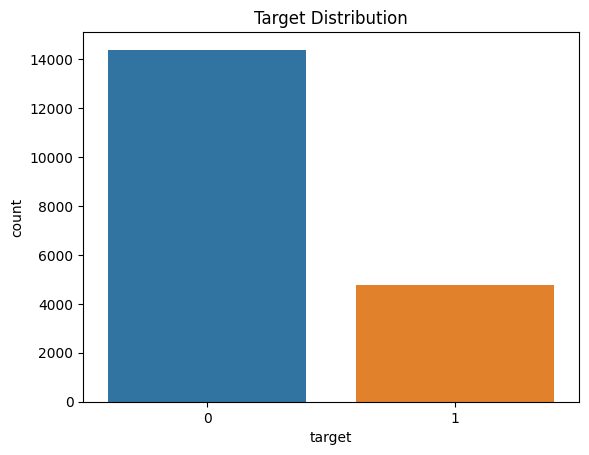

In [17]:
sns.countplot(df_visual, x='target')
plt.title('Target Distribution')
plt.show()

The dataset is highly imbalanced in favor of class 0, i.e. the willingness of an employee to keep its job.

Talking about percentages, we have:

In [18]:
percentages_df = df_visual.groupby('target').count() / len(df_visual) * 100.0
percentages_df.iloc[:, 0]

target
0    75.065247
1    24.934753
Name: enrollee_id, dtype: float64

We can now separate the target from the remaining features, to be suitable for the sklearn algorithms.

Moreover, we can avoid the *enrollee_id* column as it is just an identifier and it does not provide any useful insight

In [19]:
X = df_visual.iloc[:, 1:-1]
y = df_visual.iloc[:, -1]

print(X.shape)
print(y.shape)

(19158, 12)
(19158,)


## Explore the dataset

We can start by checking the correlation among features. In case we have an high value (positive or negative) between two or more features, we can think about excluding one of those features

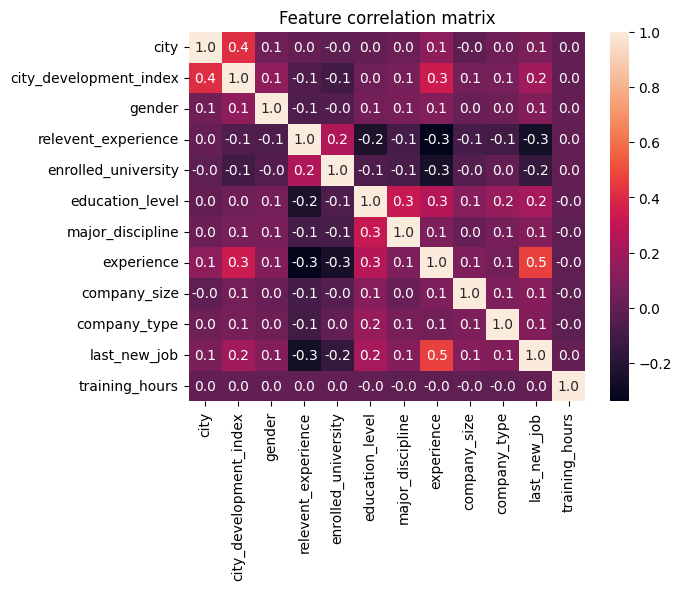

In [20]:
corr = X.corr()
sns.heatmap(corr, annot=True, fmt='.1f')
plt.title('Feature correlation matrix')
plt.show()

We can see that there are not strong correllations, but we have a noticeable relationship between experience and last_new_job. However, the value .5 is not enough to exclude one among these features.

Before diving in some data visualization, let's talk about the features type:

- city: nominal
- city_development_index: continuos
- gender: nominal
- relevent_experience: ordinal
- enrolled_university: nominal
- education level: ordinal
- major_discipline: nominal
- experience: ordinal
- company_size: ordinal
- company_type: nominal
- last_new_job: ordinal
- major_discipline: nominal
- training_hours: discrete

We will use violin plot for categorical data, kde for continuous, and histogram for descrete


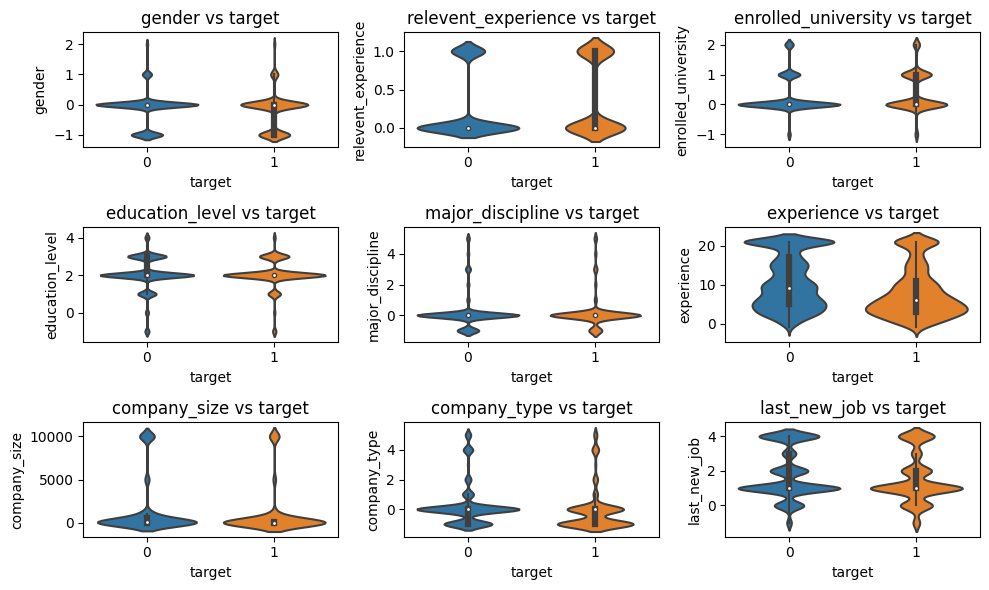

In [21]:
# let's plot the features vs target, using boxplots for categorical data and kde for continuos data
categorical_features = [
    'gender',
    'relevent_experience',
    'enrolled_university',
    'education_level',
    'major_discipline',
    'experience',
    'company_size',
    'company_type',
    'last_new_job'
]

fig, ax = plt.subplots(3, 3, figsize=(10,6))
for i, feat in enumerate(categorical_features):
    sns.violinplot(df_visual, x='target', y=feat, ax=ax[int(np.floor(i/3)), i%3])
    ax[int(np.floor(i/3)), i%3].set_title(f'{feat} vs target')
fig.tight_layout()
plt.show()


/Users/rubenberteletti/Desktop/xtream/xtream-ai-assignment/pyenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


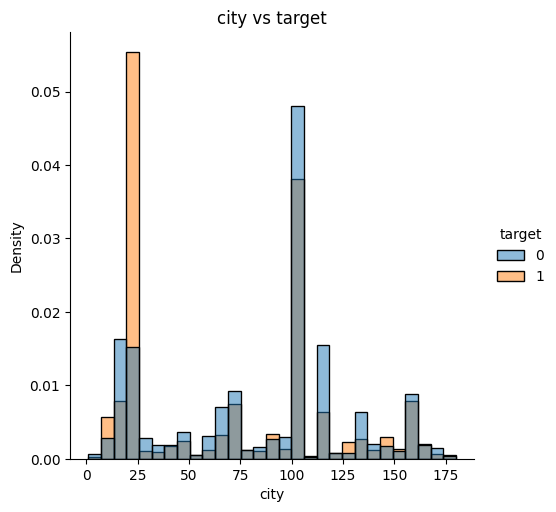

In [22]:
# histograms for discrete features 
sns.displot(df_visual, x='city', hue='target', common_norm=False, stat='density')
plt.title('city vs target')
plt.show()

In [23]:
# let's analyze which city has the the probability to leave the job higher that to keep 
keep_job_df = df_visual[df_visual.target == 0.0].groupby('city').count()['target']
leave_job_df = df_visual[df_visual.target == 1.0].groupby('city').count()['target']
# take the difference
diff = leave_job_df-keep_job_df
diff.nlargest(2)

city
21    492.0
11     47.0
Name: target, dtype: float64

In [24]:
# let's retrive its development index
print(df_visual[df_visual.city == 21]['city_development_index'].iloc[0])
print(df_visual[df_visual.city == 11]['city_development_index'].iloc[0])

0.624
0.55


/Users/rubenberteletti/Desktop/xtream/xtream-ai-assignment/pyenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


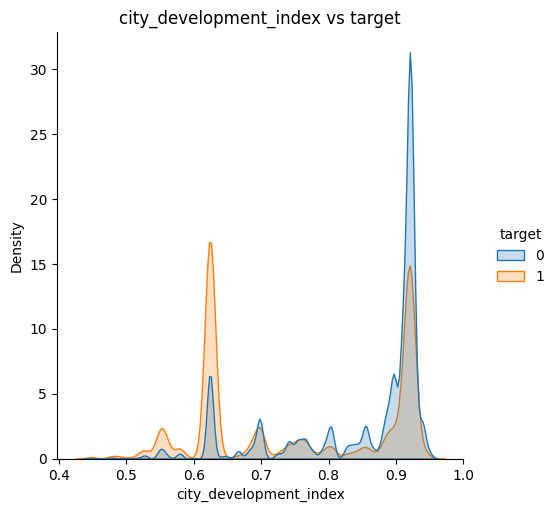

In [25]:
sns.displot(df_visual, x='city_development_index', hue='target', kind='kde', fill=True, common_norm=False, bw_adjust=.3)
plt.title('city_development_index vs target')
plt.show()

/Users/rubenberteletti/Desktop/xtream/xtream-ai-assignment/pyenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


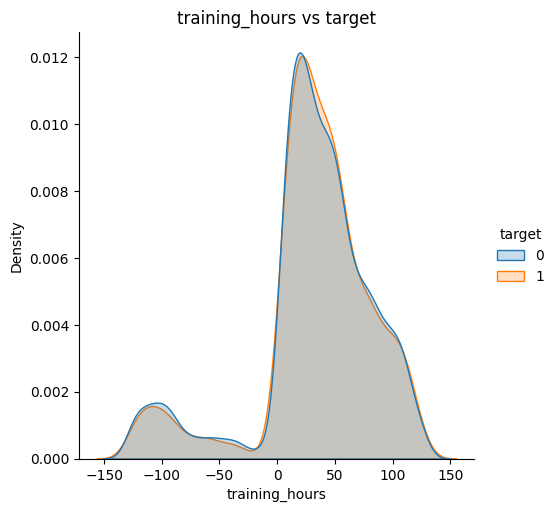

In [26]:
sns.displot(df_visual, x='training_hours', hue='target', kind='kde', fill=True, common_norm=False)
plt.title('training_hours vs target')
plt.show()

The data visualization tells us that the features that can better distinguish among a loyal and not-loyal employee are:
- experience
- city_develpment_index
- company_type

Plus, we have an anomaly in city 21, where the employees are more prone to change their job.

We can say that, because the aformentioned features have visible difference of distribution depending on the target value.

Let's go deep here.

In [27]:
# prepare some useful functions
# normalize separately
def min_max_norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def plot_feat_by_target(feat, title, xlabel):

    # separate experience by target
    loyal = df_visual[df_visual.target == 0][feat].value_counts()
    churn = df_visual[df_visual.target == 1][feat].value_counts()
    # apply minmax normalozation
    loyal = min_max_norm(loyal)
    churn = min_max_norm(churn)

    kwargs = {'alpha':.4, 'edgecolor':'k'}

    fig, ax = plt.subplots()
    ax.bar(loyal.index, loyal, **kwargs, label='Loyal')
    ax.bar(churn.index, churn, **kwargs, label='Not Loyal')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('MinMax Scores')
    ax.set_title(title)
    fig.legend()
    
    plt.show()

Analyze separately each feature with visible differences to understand what's happening

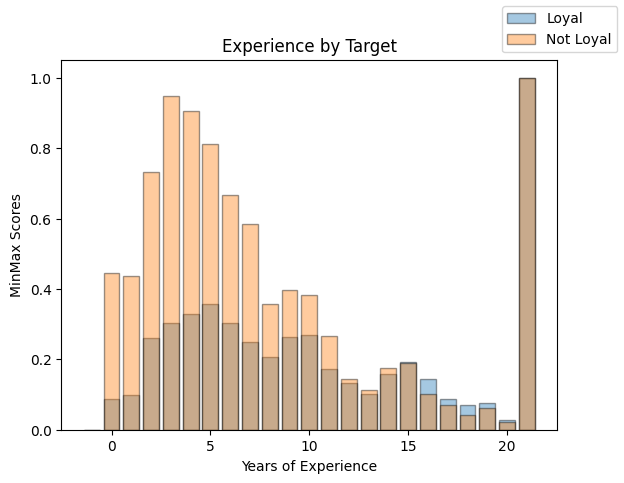

In [28]:
plot_feat_by_target('experience', 'Experience by Target', 'Years of Experience')

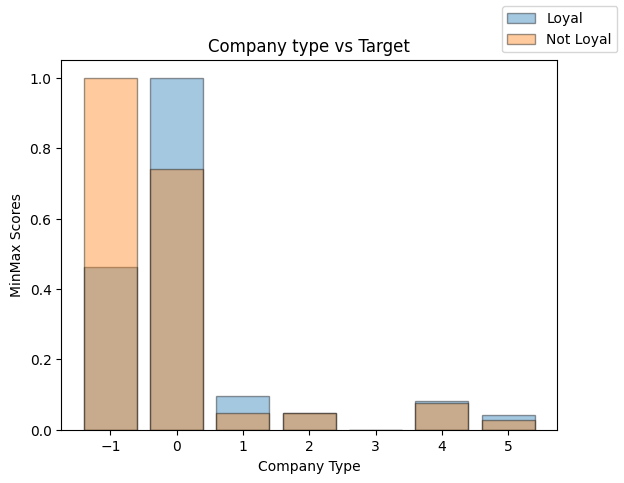

In [29]:
plot_feat_by_target('company_type', 'Company type vs Target', 'Company Type')

From the analysis we can can conclude that:
1. Employees with less than 11 years of experience are more willing to leave their job, especially those with less than 7 years
2. When an employee has a job located in a city with development index that falls in the interval [0.5 to 0.65], he has tendency to leave its job
3. If the company type is not specified, the employee has more likelyhood to change job.
4. City 21 rejects employees.

A next step could be interesting to inspect whether employees with less than 11 years are concentrated arount cities whose index falls in the aformentioned interval

/Users/rubenberteletti/Desktop/xtream/xtream-ai-assignment/pyenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/sz/0_c7pq1x46x0lrvl4jmzh97m0000gn/T/ipykernel_2322/1292276831.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


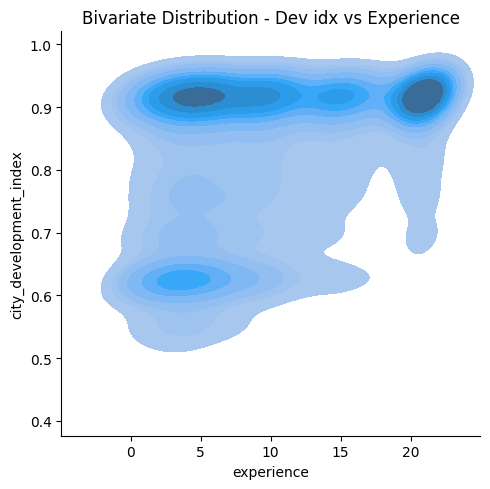

In [30]:
sns.displot(df_visual, x='experience', y='city_development_index', kind='kde', fill=True)
plt.title('Bivariate Distribution - Dev idx vs Experience')
plt.tight_layout()
plt.show()

There is no evidence of a connection of the two variables, as stated also by the correlation matrix (even if it shows only linear relationship)

## Challenge 2 - 3

Let's prepare the data to be trained.

At first we already know data the dataset is unbalanced. To deal with it we can apply an oversampling technique such as SMOTE.

Let's apply now the one hot encoding, but before fill the original df with 'not specified' instead of nan values

In [31]:
# fill nan values
df = df.fillna('not_speficied')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,2,STEM,21,-1,not_speficied,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,2,STEM,15,50,Pvt Ltd,4,47,0.0
2,11561,21,0.624,not_speficied,No relevent experience,Full time course,2,STEM,5,-1,not_speficied,0,83,0.0
3,33241,115,0.789,not_speficied,No relevent experience,not_speficied,2,Business Degree,0,-1,Pvt Ltd,0,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,3,STEM,21,50,Funded Startup,4,8,0.0


In [32]:
from sklearn.preprocessing import OneHotEncoder

# instantiate the encoder
enc = OneHotEncoder()
# separate featuers to be encoded
X_to_encode = df[['city', 'gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']]
# get the targets
y = df.iloc[:, -1]
# apply the encoding
X_to_encode = enc.fit_transform(X_to_encode).toarray()
# create a DataFrame from the encoded data
encoded_df = pd.DataFrame(X_to_encode, columns=enc.get_feature_names_out(enc.feature_names_in_))
# get the non-categorical features from the original DataFrame
non_categorical_cols = ['city_development_index', 'experience', 'company_size', 'last_new_job', 'training_hours', 'education_level']
X_non_categorical = df[non_categorical_cols]
# combine the encoded and non-categorical features
X_encoded = pd.concat([X_non_categorical, encoded_df], axis=1)
X_encoded.head()


,city_development_index,experience,company_size,last_new_job,training_hours,education_level,city_1,city_2,city_7,city_8,...,major_discipline_Other,major_discipline_STEM,major_discipline_not_speficied,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_not_speficied
0,0.920,21,-1,1,36,2,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.776,15,50,4,47,2,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.624,5,-1,0,83,2,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.789,0,-1,0,52,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.767,21,50,4,8,3,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Now we have 152 features due to the OneHotEncoding tecnique. To keep interpretabiliy, we need to reduce the amount of features.

One way of doing that is to use the feature_selection module provided by sklearn, using the *SelectKBest* class. It requires a scoring function to ptoperly select the best features, and among those available we can use *f_scoring*, that basically performs an ANalysis Of VAriance by computing the difference in means of features values belonging to different classes, then, it selects the most discriminative.

In our case, we have to privilege interpretability, thus, we will keep the number of feautures as low as possible

In [41]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_selector = SelectKBest(f_classif, k=4)
X_new = feature_selector.fit_transform(X_encoded, y)
best_features = feature_selector.get_feature_names_out()
# create a new dataframe
X_final = pd.DataFrame(X_new, columns=best_features)
X_final.head()


,city_development_index,experience,city_21,company_type_not_speficied
0,0.920,21.0,0.0,1.0
1,0.776,15.0,0.0,0.0
2,0.624,5.0,1.0,1.0
3,0.789,0.0,0.0,0.0
4,0.767,21.0,0.0,0.0


This confirms the results obtained with the exploratory analysis and data visualization

In [34]:
# import the library
from imblearn.over_sampling import SMOTE

# apply the oversampling
X_over, y_over = SMOTE().fit_resample(X_final, y)

# explore the result before, and after
print('BEFORE SMOTE')
print(np.unique(y, return_counts=True))
print('AFTER SMOTE')
print(np.unique(y_over, return_counts=True))

BEFORE SMOTE
(array([0., 1.]), array([14381,  4777]))
AFTER SMOTE
(array([0., 1.]), array([14381, 14381]))


Now the two classes are perfectly balanced.

We are ready to select a model suited for our task. As we mostly want interpretable result, we can adopt the Decision Tree Classifier.

As strategy to fit the dataset, we can adopt the cross validation method, using the accuracy as reference metric.

In [35]:
from sklearn.model_selection import cross_validate

tree = DecisionTreeClassifier(random_state=0, max_depth=3)
result = cross_validate(tree, X_over, y_over, cv=5, scoring='accuracy', return_estimator=True)
# the result variable as defiend above is a dictionary with a set of keys
print(result.keys())
result['test_score']


dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])


array([0.73509473, 0.73613767, 0.73296245, 0.7261822 , 0.74217663])

In the results there are many metrics. In this case we are interested in 'estimator' and 'test_score'.

With the latter key we can get the model performance over the 5 splits defined in the cross_validate method, and through estimator we can get the best model

In [36]:
# Print mean and std of 5 splits
print(f'Mean Accuracy: {result["test_score"].mean():.2f}\tStd: {result["test_score"].std():.2f}')
# get the best classifier, the one with highest accuracy
best_tree = result['estimator'][np.argmax(result['test_score'])]

Mean Accuracy: 0.73	Std: 0.01


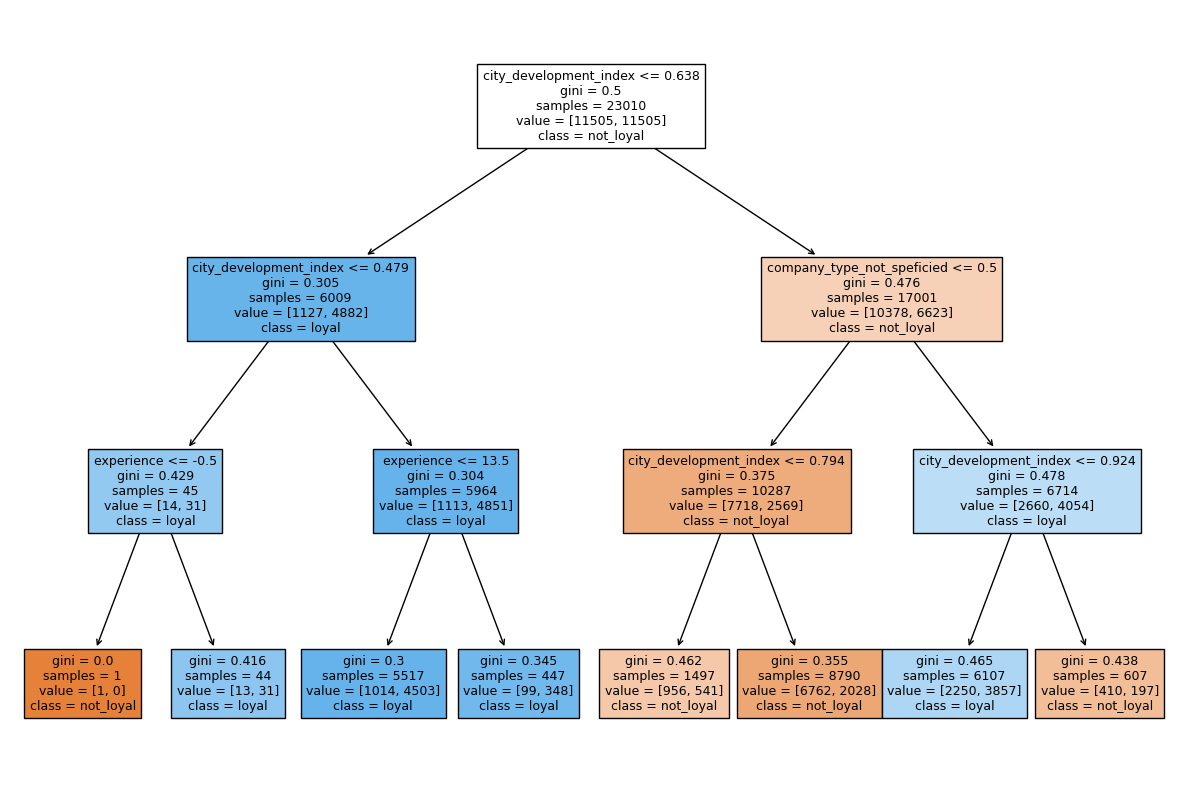

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
# map labels to string to more interpretability
y_map = {0:'loyal', 1:'not_loyal'}
y_str = y_over.map(lambda label: y_map[label]).to_list()
plot_tree(best_tree, feature_names=X_final.columns.tolist(), filled=True, ax=ax, fontsize=9, class_names=y_str)
plt.show()

Let's pick at random few samples, and test the model

In [38]:
samples = X_final.sample(10, random_state=0)
y_true = y_over[samples.index]

y_preds = best_tree.predict(samples)

print('True Labels:')
print(y_true.to_list())
print('Predicted Labels:')
print(list(y_preds))

True Labels:
[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
Predicted Labels:
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]


As we can see the model is pretty accurate, reaching on 5 validation split and accuracy of 73% ± 0.01, even in its simplicity.

To have a complete view, let's see the performance of the full model with all the features involved

In [39]:
# apply SMOTE
X_full, y_full = SMOTE().fit_resample(X_encoded, y)
# define the tree
tree = DecisionTreeClassifier(random_state=0)
result_full = cross_validate(tree, X_over, y_over, cv=5, scoring='accuracy')
# print the stats
print(f'Mean Accuracy: {result_full["test_score"].mean():.2f}\tStd: {result_full["test_score"].std():.2f}')

Mean Accuracy: 0.78	Std: 0.03


We lost roughly 5% points, but we gain in interpretability, we have than a pretty good trade-off!